# 02 · 预处理复核（ICU Lymphoma ML）

> 本 Notebook 复核 `src.preprocess` 的产物：特征矩阵、缺失、独热后维度、train/test 一致性等，并输出若干图表至 `outputs/figures/`。

In [3]:
# %% [bootstrap deps] —— 在当前 Notebook 内核中自动补齐依赖
import sys, subprocess, importlib

# 映射：{ import_name: pip_spec }
REQ = {
    "joblib": "joblib==1.4.2",
    "yaml": "pyyaml==6.0.2",          # 注意：导入名 yaml，pip 包名 pyyaml
    "pyarrow": "pyarrow==16.1.0",
    "openpyxl": "openpyxl==3.1.5",
    # 如需再补： "tqdm": "tqdm==4.66.4", "seaborn": "seaborn==0.13.2",
}

def ensure(import_name: str, pip_spec: str):
    try:
        importlib.import_module(import_name)
        print(f"[ok] {import_name} already available")
        return
    except Exception:
        pass
    print(f"[setup] installing {pip_spec} ...")
    # 静默安装，尽量少输出
    r = subprocess.run(
        [sys.executable, "-m", "pip", "install", pip_spec, "-q", "--disable-pip-version-check", "--no-input"],
        capture_output=True, text=True
    )
    if r.returncode != 0:
        # 打印少量错误摘要
        print(r.stderr.splitlines()[-5:])
        raise RuntimeError(f"pip install failed: {pip_spec}")
    importlib.invalidate_caches()
    importlib.import_module(import_name)
    print(f"[ok] {import_name} ready")

for imp, spec in REQ.items():
    ensure(imp, spec)

print("[done] dependency bootstrap complete.")


[ok] joblib already available
[ok] yaml already available
[ok] pyarrow already available
[setup] installing openpyxl==3.1.5 ...
[ok] openpyxl ready
[done] dependency bootstrap complete.


In [4]:
# %% [imports & paths]
from pathlib import Path
import json, warnings, subprocess, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yaml, joblib

PROJECT_ROOT = Path.cwd().resolve().parents[0] if Path.cwd().name == "notebooks" else Path.cwd()
CONF_PATH = PROJECT_ROOT / "conf" / "config.yaml"

with open(CONF_PATH, "r", encoding="utf-8") as f:
    CFG = yaml.safe_load(f)

PROC_DIR = PROJECT_ROOT / CFG.get("data", {}).get("processed_dir", "data_processed")
RAW_DIR  = PROJECT_ROOT / CFG.get("data", {}).get("raw_dir", "data_raw")
OUTCOME  = CFG.get("data", {}).get("outcome_col", "mor_hospital")
FIG_DIR  = PROJECT_ROOT / CFG.get("output", {}).get("figures", "outputs/figures/")
TAB_DIR  = PROJECT_ROOT / CFG.get("output", {}).get("tables", "outputs/tables/")
FIG_DIR.mkdir(parents=True, exist_ok=True)
TAB_DIR.mkdir(parents=True, exist_ok=True)

print("[paths]\n",
      " processed_dir:", PROC_DIR, "\n",
      " raw_dir      :", RAW_DIR,  "\n",
      " figures_dir  :", FIG_DIR,   "\n",
      " tables_dir   :", TAB_DIR,   "\n",
      " outcome_col  :", OUTCOME)

# 统一图形风格（优先项目内方法）
def _fallback_mpl_style():
    plt.rcParams.update({
        "figure.dpi": 120,
        "savefig.dpi": 300,
        "axes.titlesize": 12,
        "axes.labelsize": 11,
        "xtick.labelsize": 10,
        "ytick.labelsize": 10,
        "legend.fontsize": 10,
        "lines.linewidth": 1.8,
        "axes.grid": True,
        "grid.alpha": 0.2
    })
try:
    from src.data_utils import apply_mpl_style
    apply_mpl_style()
    print("[style] using src.data_utils.apply_mpl_style")
except Exception:
    _fallback_mpl_style()
    print("[style] using fallback mpl style")

# 确保 parquet 引擎
def ensure_pyarrow():
    try:
        import pyarrow  # noqa
        return
    except Exception:
        print("[setup] installing pyarrow==16.1.0 ...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", "pyarrow==16.1.0", "-q"]) 
        print("[ok] pyarrow ready.")
ensure_pyarrow()

[paths]
  processed_dir: /public/home/aojiang/海南医科大学/icu-lymphoma-ml-repro/data_processed 
  raw_dir      : /public/home/aojiang/海南医科大学/icu-lymphoma-ml-repro/data_raw 
  figures_dir  : /public/home/aojiang/海南医科大学/icu-lymphoma-ml-repro/outputs/figures 
  tables_dir   : /public/home/aojiang/海南医科大学/icu-lymphoma-ml-repro/outputs/tables 
  outcome_col  : mor_hospital
[style] using fallback mpl style


## 1. （可选）一键执行预处理脚本
如需在 Notebook 内重跑 `src.preprocess`，取消下一格的注释运行即可。

In [ ]:
# %% [optional run preprocess]
# run_pre = False
# if run_pre:
#     print("[run] python -m src.preprocess --config conf/config.yaml")
#     ret = subprocess.run([sys.executable, "-m", "src.preprocess", "--config", str(CONF_PATH)], capture_output=True, text=True)
#     print(ret.stdout)
#     if ret.returncode != 0:
#         print(ret.stderr)
#         raise RuntimeError("preprocess failed")

## 2. 加载预处理产物
- 主要文件：`features_processed.parquet`、`missingness_overview.csv`、`feature_schema.json`、`split_idx.joblib`

In [5]:
# %% [load artifacts]
fp_feat = PROC_DIR / "features_processed.parquet"
fp_miss = PROC_DIR / "missingness_overview.csv"
fp_schema = PROJECT_ROOT / "outputs" / "artifacts" / "feature_schema.json"
fp_split  = PROJECT_ROOT / "outputs" / "artifacts" / "split_idx.joblib"

df = pd.read_parquet(fp_feat)
print(f"[load] features_processed: {df.shape}")

miss_df = pd.read_csv(fp_miss) if fp_miss.exists() else None
if miss_df is None:
    warnings.warn("缺失概览不存在，将基于当前 df 现场统计。")
    miss_df = (
        df.isna().sum().rename("n_missing").reset_index().rename(columns={"index":"column"})
    )
    miss_df["n"] = len(df)
    miss_df["pct_missing"] = miss_df["n_missing"]/miss_df["n"]
    miss_df["dtype"] = miss_df["column"].map(lambda c: str(df[c].dtype))
else:
    if "pct_missing" not in miss_df.columns and {"n_missing","n"}.issubset(miss_df.columns):
        miss_df["pct_missing"] = miss_df["n_missing"]/miss_df["n"]

schema = json.loads(fp_schema.read_text(encoding="utf-8")) if fp_schema.exists() else {}
split_idx = joblib.load(fp_split) if fp_split.exists() else None
if split_idx is None:
    warnings.warn("未找到 split_idx.joblib，将跳过 train/test 对比。")

display(pd.DataFrame([{"n_rows": len(df), "n_cols": df.shape[1]}]))
if OUTCOME in df.columns:
    prev = df[OUTCOME].mean()
    print(f"[stat] prevalence = {prev:.4f} ({prev*100:.2f}%)")

[load] features_processed: (1591, 39)


,n_rows,n_cols
0,1591,39


[stat] prevalence = 0.2150 (21.50%)


## 3. 缺失统计与 Top10 可视化
展示缺失率 Top10，并保存图表至 `outputs/figures/overview_missing_top10_preproc.png`。

,column,dtype,n_missing,pct_missing
0,aptt,float64,176,11.062225
1,inr,float64,158,9.930861
2,pt,float64,158,9.930861
3,calcium,float64,68,4.274041
4,temperature,float64,35,2.199874
5,glucose,float64,20,1.257071
6,wbc,float64,19,1.194217
7,sodium,float64,18,1.131364
8,chloride,float64,17,1.068510
9,aniongap,float64,17,1.068510


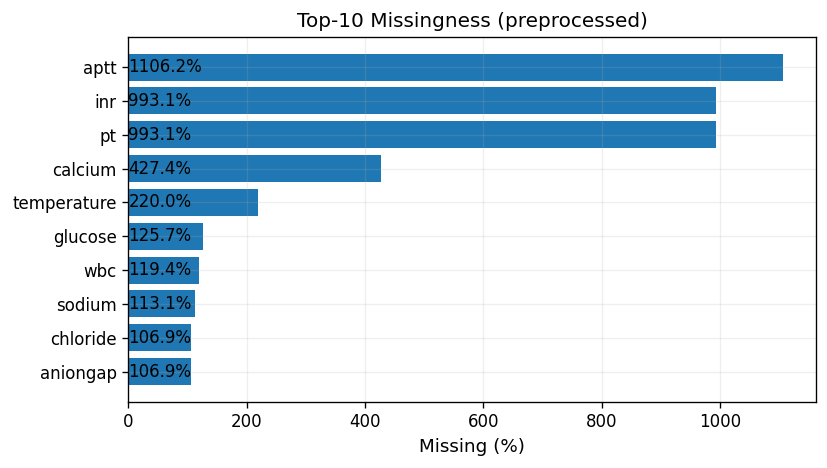

[save] /public/home/aojiang/海南医科大学/icu-lymphoma-ml-repro/outputs/figures/overview_missing_top10_preproc.png


In [6]:
# %% [missingness top10]
miss_top = miss_df.sort_values("pct_missing", ascending=False).head(10).copy()
display(miss_top)

fig, ax = plt.subplots(figsize=(7,4))
ax.barh(miss_top["column"], miss_top["pct_missing"]*100)
ax.invert_yaxis()
for ytick, v in zip(ax.get_yticks(), miss_top["pct_missing"].values):
    ax.text(0.5, ytick, f"{v*100:.1f}%", va="center")
ax.set_xlabel("Missing (%)")
ax.set_title("Top-10 Missingness (preprocessed)")
fig.tight_layout()
outp = FIG_DIR / "overview_missing_top10_preproc.png"
fig.savefig(outp)
plt.show()
print(f"[save] {outp}")

# 也保存表格副本
miss_top.to_csv(TAB_DIR / "missing_top10_preproc.csv", index=False)

## 4. 独热编码后维度与列名速览
从 `feature_schema.json` 读取 `continuous` 与 `categorical` 的映射，并对比当前 DataFrame 的列名（独热后）。

In [7]:
# %% [OHE columns]
cont_cols = schema.get("continuous", []) if isinstance(schema, dict) else []
cat_cols  = schema.get("categorical", []) if isinstance(schema, dict) else []
print(f"[schema] continuous={len(cont_cols)}, categorical={len(cat_cols)}")

cur_cols = df.columns.tolist()
print(f"[df] columns total={len(cur_cols)} (including outcome + OHE)")
display(pd.DataFrame({"column": cur_cols}).head(30))

# 粗略识别 OHE 产生的新列（以原始分类变量名为前缀）
suspected_ohe = []
for c in cat_cols:
    suspected_ohe += [col for col in cur_cols if col.startswith(f"{c}_")]
print(f"[ohe] suspected new columns from categorical={len(set(suspected_ohe))}")
display(pd.DataFrame({"ohe_col": sorted(set(suspected_ohe))}).head(30))

[schema] continuous=21, categorical=0
[df] columns total=39 (including outcome + OHE)


,column
0,age
1,heart_rate
2,sbp
3,spo2
4,platelets
5,bicarbonate
6,bun
7,pt
8,aptt
9,temperature


[ohe] suspected new columns from categorical=0


,ohe_col


## 5. 分位数截尾演示（示例）
代码中我们做了分位数截尾（默认 `[0.001, 0.999]`）。这里选取少量连续变量演示其分布（截尾前/后）。

> 注意：`features_processed.parquet` 已经是**截尾后**的矩阵。为了演示，我们从原始 Excel 回读同名列来做“截尾前”的对比图。若原始数据不在同一路径，将只展示“截尾后”的分布。

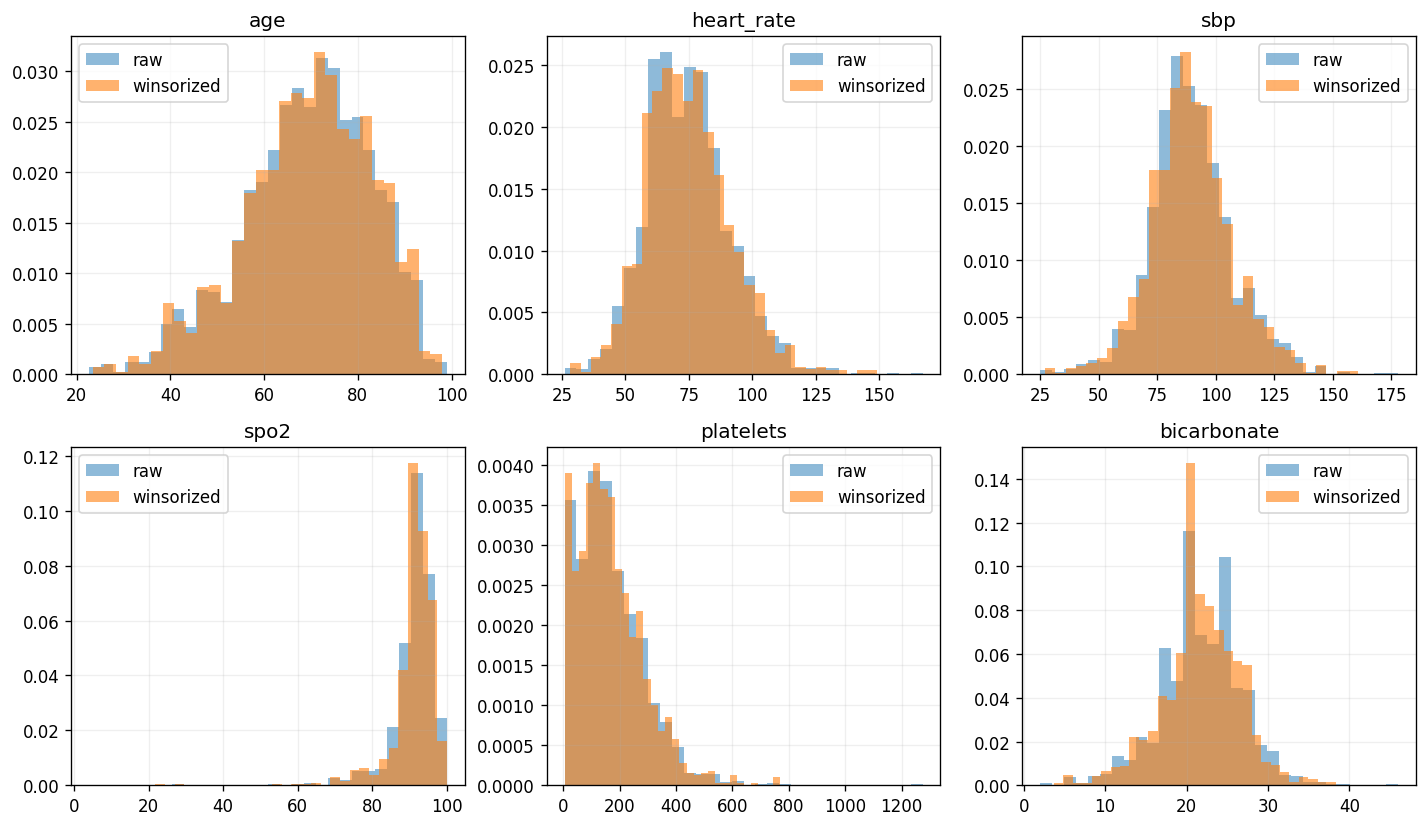

[save] /public/home/aojiang/海南医科大学/icu-lymphoma-ml-repro/outputs/figures/preproc_winsorization_demo.png


In [8]:
# %% [winsorization demo]
demo_cols = [c for c in cont_cols if c in df.columns][:6]  # 选前 6 个连续变量
if not demo_cols:
    print("[skip] 无可用于演示的连续变量。")
else:
    # 回读原始 excel
    raw_df = None
    for f in CFG.get("data", {}).get("input_files", ["data.xlsx"]):
        p = RAW_DIR / f
        if p.exists():
            try:
                raw_df = pd.read_excel(p)
                break
            except Exception as e:
                warnings.warn(f"无法读取 {p}: {e}")
    nplots = len(demo_cols)
    ncols = 3
    nrows = int(np.ceil(nplots/ncols))
    fig, axes = plt.subplots(nrows, ncols, figsize=(12, 3.5*nrows))
    axes = axes.ravel()
    for i, col in enumerate(demo_cols):
        ax = axes[i]
        if raw_df is not None and col in raw_df.columns:
            ax.hist(raw_df[col].dropna(), bins=30, alpha=0.5, label="raw", density=True)
        ax.hist(df[col].dropna(), bins=30, alpha=0.6, label="winsorized", density=True)
        ax.set_title(col)
        ax.legend()
    for j in range(i+1, len(axes)):
        axes[j].axis("off")
    fig.tight_layout()
    outp = FIG_DIR / "preproc_winsorization_demo.png"
    fig.savefig(outp)
    plt.show()
    print(f"[save] {outp}")

## 6. Train/Test 一致性检查
读取 `split_idx.joblib`，对比主要统计量（仅数值变量展示）与结局阳性率（如存在）。

> 结局分布在我们 `src.ingest` 中已分层拆分，这里仅复核。

[split] train=(1113, 39), test=(478, 39)


,feature,train_mean,test_mean,train_std,test_std
0,age,69.277231,69.476931,13.326055,14.141623
1,heart_rate,75.034613,73.874451,16.589746,16.385156
2,sbp,89.644509,90.035941,17.247343,18.107166
3,spo2,90.692853,91.199916,6.973655,6.309702
4,platelets,166.229392,170.536842,116.708082,115.157442
5,bicarbonate,21.727703,21.779998,4.831910,4.944780
6,bun,25.623759,26.006614,19.109463,19.442889
7,pt,14.984521,14.920737,5.839659,5.663561
8,aptt,33.047934,32.332477,16.195448,11.068477
9,temperature,36.331545,36.317045,0.677268,0.617216


[prev] train=0.2147 (21.47%), test=0.2155 (21.55%)


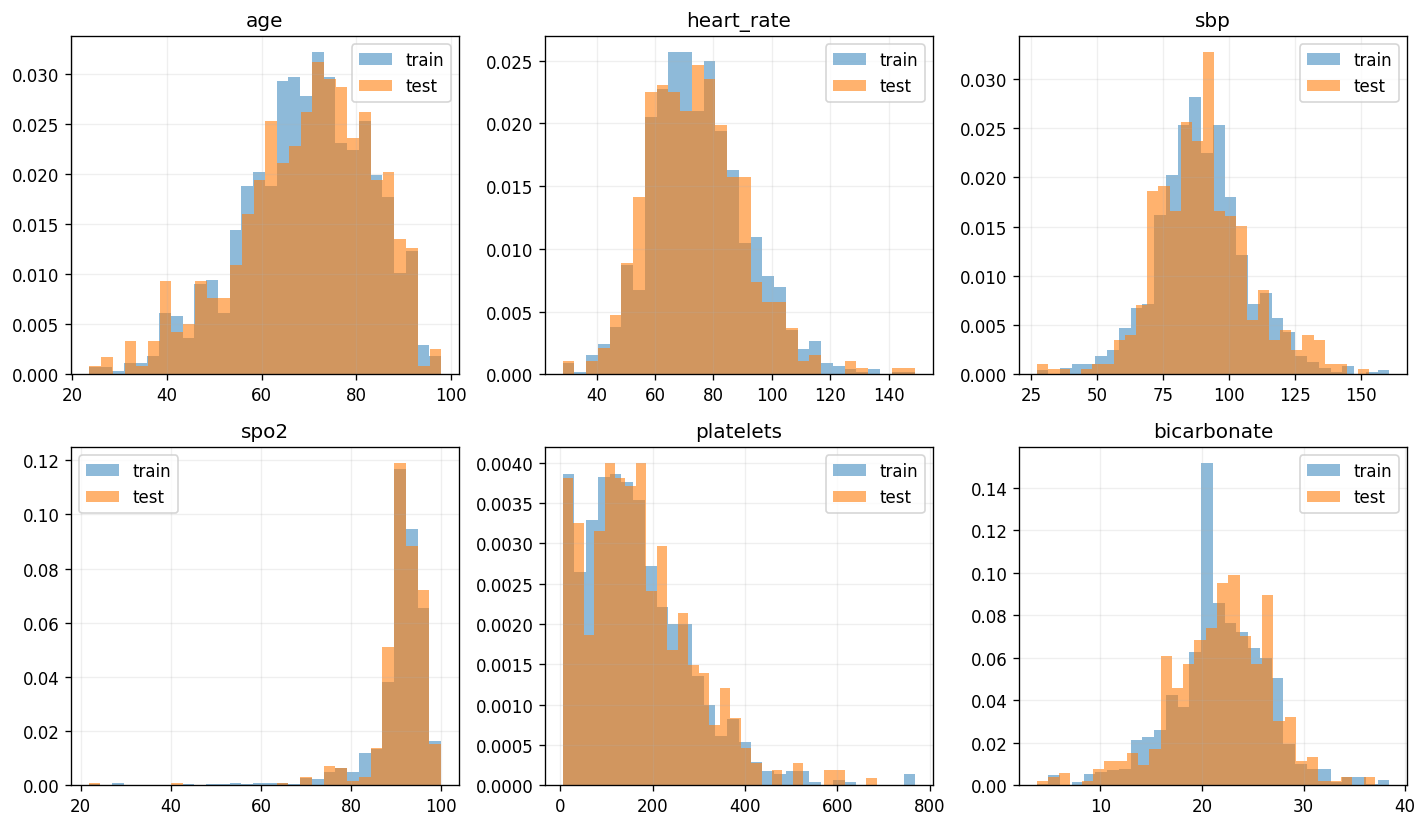

[save] /public/home/aojiang/海南医科大学/icu-lymphoma-ml-repro/outputs/figures/preproc_train_test_distribution.png


In [9]:
# %% [train/test check]
if split_idx is None or not {"train_idx","test_idx"}.issubset(split_idx):
    print("[skip] 缺少 split 索引，跳过该节。")
else:
    tr = df.iloc[split_idx["train_idx"]].copy()
    te = df.iloc[split_idx["test_idx"]].copy()
    print(f"[split] train={tr.shape}, test={te.shape}")
    num_cols = [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c]) and c != OUTCOME]
    # 取前 10 个数值列简要对比
    sel = num_cols[:10]
    stats = []
    for c in sel:
        stats.append({
            "feature": c,
            "train_mean": float(tr[c].mean()),
            "test_mean": float(te[c].mean()),
            "train_std": float(tr[c].std()),
            "test_std": float(te[c].std()),
        })
    stats_df = pd.DataFrame(stats)
    display(stats_df)
    stats_df.to_csv(TAB_DIR / "train_test_numeric_compare.csv", index=False)
    
    if OUTCOME in df.columns:
        prev_tr = tr[OUTCOME].mean()
        prev_te = te[OUTCOME].mean()
        print(f"[prev] train={prev_tr:.4f} ({prev_tr*100:.2f}%), test={prev_te:.4f} ({prev_te*100:.2f}%)")
    
    # 可视化：测试集前 6 个数值特征的分布
    cols_vis = sel[:6]
    if cols_vis:
        nplots = len(cols_vis)
        ncols = 3
        nrows = int(np.ceil(nplots/ncols))
        fig, axes = plt.subplots(nrows, ncols, figsize=(12, 3.5*nrows))
        axes = axes.ravel()
        for i, col in enumerate(cols_vis):
            ax = axes[i]
            ax.hist(tr[col].dropna(), bins=30, alpha=0.5, label="train", density=True)
            ax.hist(te[col].dropna(), bins=30, alpha=0.6, label="test", density=True)
            ax.set_title(col)
            ax.legend()
        for j in range(i+1, len(axes)):
            axes[j].axis("off")
        fig.tight_layout()
        outp = FIG_DIR / "preproc_train_test_distribution.png"
        fig.savefig(outp)
        plt.show()
        print(f"[save] {outp}")

## 7. 小结
- 维度、缺失与 OHE 确认
- Train/Test 一致性基本正常
- 下一步建议：`src.multiple_imputation`（MICE + 标准化）与 `src.feature_select`（LASSO+1SE）

本 Notebook 仅复核，不干预流水线写盘。所有图表已保存到 `outputs/figures/`，表格到 `outputs/tables/`。